In [1]:
%%capture
import sys
!pip install tensorflow-addons
!pip install yfinance
!git clone https://github.com/ICascha/QuantGANs-replication.git
sys.path.append('/content/QuantGANs-replication/')

In [2]:
from backend.preprocessing import *
from backend.metrics import *
from backend.tcn import make_TCN
from backend.clustering import *

import pandas_datareader as pdr
import yfinance as yf
yf.pdr_override()
import matplotlib.pyplot as plt
import numpy as np

from google.colab import files
from time import sleep

In [3]:
df = pdr.get_data_yahoo("^GSPC", start="2009-1-1", end="2019-12-31")['Adj Close']
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)

In [4]:
s1 = StandardScaler()

# receptive field size
rfs = 127

# pre-processing pipeline
log_returns_preprocessed = s1.fit_transform(log_returns)
log_returns_rolled = rolling_window(log_returns_preprocessed, rfs)

In [5]:
# TRAINING CODE TAKEN FROM: https://colab.research.google.com/github/timsainb/tensorflow2-generative-models/blob/master/3.0-WGAN-GP-fashion-mnist.ipynb
# WITH MINOR MODIFICATIONS
import tensorflow as tf

class WGAN(tf.keras.Model):
    """
    I used github/LynnHo/DCGAN-LSGAN-WGAN-GP-DRAGAN-Tensorflow-2/ as a reference on this.
    
    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(WGAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x, d=False):
        """ passes through the network and computes loss
        """
        ### pass through network
        # generating noise from a uniform distribution

        z_samp = tf.random.normal([x.shape[0], 1, rfs*2-1, self.n_Z])

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)

        # gradient penalty
        d_regularizer = self.gradient_penalty(x, x_gen)
        ### losses
        disc_loss = (
            tf.reduce_mean(logits_x)
            - tf.reduce_mean(logits_x_gen)
            + d_regularizer * self.gradient_penalty_weight
        )

        
        # losses of fake with label "1"
        gen_loss = tf.reduce_mean(logits_x_gen)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)

        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def compute_gradients_d(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)


        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )

    def apply_gradients_d(self, disc_gradients):

        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )

    def gradient_penalty(self, x, x_gen):
        epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
        x_hat = epsilon * x + (1 - epsilon) * x_gen
        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = self.discriminate(x_hat)
        gradients = t.gradient(d_hat, x_hat)
        ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
        d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
        return d_regularizer

    @tf.function
    def train(self, train_x):

        for _ in range(4):
            disc_gradients = self.compute_gradients_d(train_x)
            self.apply_gradients_d(disc_gradients)

        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)

In [6]:
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model

dilations = 2**(np.arange(6))
n_filters = 50

discriminator_input = [1, rfs, 1]

d = make_TCN(dilations, n_filters, 0, False, False, False, discriminator_input)

input_layer = Input(shape=discriminator_input)
output_layer = d(input_layer)
output_layer = Flatten()(output_layer)

discriminator = Model(input_layer, output_layer)
generator = make_TCN(dilations, n_filters, 0, True, False, False, [1, None, 3])

In [7]:
import tensorflow as tf
gen_optimizer = tf.keras.optimizers.Adam(6e-5, epsilon=1e-8, beta_1=0.0, beta_2=0.9)
disc_optimizer = tf.keras.optimizers.Adam(1.8e-4, epsilon=1e-8, beta_1=0.0, beta_2=0.9)
# model
model = WGAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    n_Z = 3,
    gradient_penalty_weight = 10.0
)

data = np.expand_dims(np.moveaxis(log_returns_rolled, 0,1), 1).astype('float32')
batch_size = 64

In [8]:
fixed_noise = tf.random.normal([128, 1, 4000, 3])
acf_real = acf(log_returns_preprocessed, 63)
abs_acf_real = acf(log_returns_preprocessed**2, 63)
le_real = acf(log_returns_preprocessed, 63, le=True)


n_steps = 10000
for epoch in range(n_steps):
    # train
    batch_idx = np.random.choice(np.arange(data.shape[0]), size=batch_size, replace=(batch_size > data.shape[0]))
    batch = data[batch_idx]
    model.train(batch)
    # test on holdout
    if epoch % 300 == 0:
        y = generator(fixed_noise).numpy().squeeze()
        scores = []
        scores.append(np.linalg.norm(acf_real - acf(y.T, 63).mean(axis=1, keepdims=True)))
        scores.append(np.linalg.norm(abs_acf_real - acf(y.T**2, 63).mean(axis=1, keepdims=True)))
        scores.append(np.linalg.norm(le_real - acf(y.T, 63, le=True).mean(axis=1, keepdims=True)))
        print("\nacf: {:.4f}, acf_abs: {:.4f}, le: {:.4f}".format(*scores))


acf: 0.2358, acf_abs: 1.2959, le: 0.6869

acf: 0.2114, acf_abs: 1.2746, le: 0.2597

acf: 0.2187, acf_abs: 1.1516, le: 0.2643

acf: 0.2196, acf_abs: 1.0009, le: 0.2857

acf: 0.2119, acf_abs: 0.9061, le: 0.2827

acf: 0.1916, acf_abs: 0.8341, le: 0.2734

acf: 0.1900, acf_abs: 0.7701, le: 0.2821

acf: 0.1925, acf_abs: 0.7105, le: 0.2744

acf: 0.1977, acf_abs: 0.6548, le: 0.2869

acf: 0.2037, acf_abs: 0.5952, le: 0.2808

acf: 0.2046, acf_abs: 0.5855, le: 0.2670

acf: 0.2054, acf_abs: 0.5566, le: 0.2565

acf: 0.2037, acf_abs: 0.5688, le: 0.2490

acf: 0.2023, acf_abs: 0.5680, le: 0.2525

acf: 0.2024, acf_abs: 0.5704, le: 0.2569

acf: 0.2024, acf_abs: 0.5526, le: 0.2305

acf: 0.1996, acf_abs: 0.5387, le: 0.2474

acf: 0.1980, acf_abs: 0.5157, le: 0.2288

acf: 0.1998, acf_abs: 0.5147, le: 0.2256

acf: 0.1968, acf_abs: 0.5051, le: 0.2197

acf: 0.1973, acf_abs: 0.4966, le: 0.2331

acf: 0.1932, acf_abs: 0.4745, le: 0.2145

acf: 0.1957, acf_abs: 0.4618, le: 0.2161

acf: 0.1936, acf_abs: 0.4742, le:

In [9]:
generator.save('trained_wgan_generator_sp500')

In [10]:
!zip -r trained_wgan_generator_sp500.zip trained_wgan_generator_sp500/ 

In [11]:
sleep(20)
files.download('trained_wgan_generator_sp500.zip')

In [12]:
noise = tf.random.normal([1024, 1, len(log_returns_preprocessed) + rfs - 1, 3])
y = generator(noise).numpy().squeeze()

y = (y - y.mean(axis=0))/y.std(axis=0)
y = s1.inverse_transform(y)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

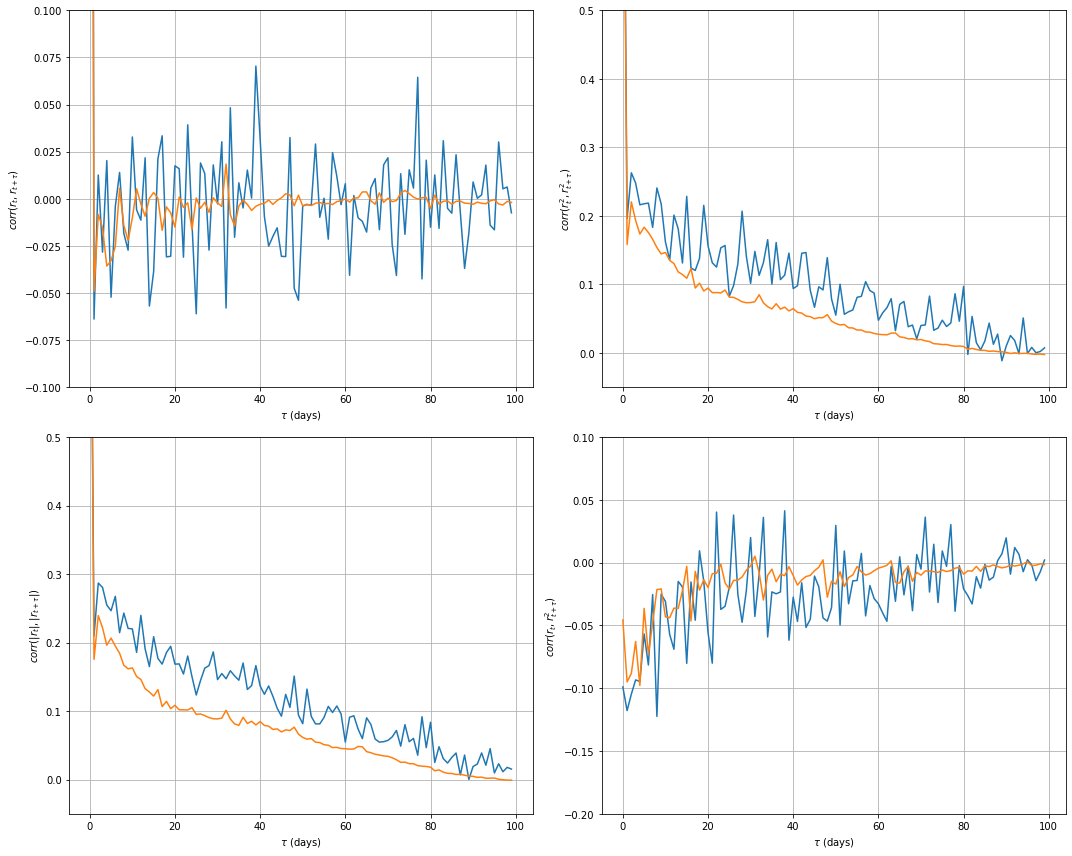

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

axs[0, 0].plot(acf(log_returns, 100))
axs[0, 0].plot(acf(y.T, 100).mean(axis=1))
axs[0, 0].set_ylim(-0.1, 0.1)
axs[0, 0].set_ylabel('$corr(r_t, r_{t+\\tau})$')

axs[0, 1].plot(acf(log_returns**2, 100))
axs[0, 1].set_ylim(-0.05, 0.5)
axs[0, 1].set_ylabel('$corr(r_t^2, r_{t+\\tau}^2)$')
axs[0, 1].plot(acf(y.T**2, 100).mean(axis=1))

axs[1, 0].plot(acf(abs(log_returns), 100, le=False))
axs[1, 0].plot(acf(abs(y.T), 100, le=False).mean(axis=1))
axs[1, 0].set_ylim(-0.05, 0.5)
axs[1, 0].set_ylabel('$corr(|r_t|, |r_{t+\\tau}|)$')

axs[1, 1].plot(acf(log_returns, 100, le=True))
axs[1, 1].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[1, 1].set_ylim(-0.2, 0.1)
axs[1, 1].set_ylabel('$corr(r_t, r_{t+\\tau}^2)$')

for ax in axs.ravel(): ax.grid(True)
plt.setp(axs, xlabel='$\\tau$ (days)')
plt.tight_layout()

plt.savefig('wgan_dependency.png', dpi=300)
files.download("wgan_dependency.png");

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from backend.preprocessing import rolling_window
from sklearn.cluster import KMeans


def clustering(real_returns, synth_returns, window_length, n_clusters, random_state=0):
    """cluster real and synthetic returns. Synthetic returns are used to determine cluster
    

    Args:
        real_returns (2d-array): real returns in shape (timesteps, 1)
        synth_returns (2d-array): synthetic returns in shape (timesteps, samples)
        window_length (int): length of moving window, skips across 2*window_length when moving
        n_clusters (int): number of clusters
        random_state (int, optional): seed of kmeans RNG. Defaults to 0.

    Returns:
        tuple: tuple of real and synthetic samples, their corresponding bins, 
        array of total frequency of both real and synthetic returns and a fitted kmeans object
    """    

    real_samples = rolling_window(real_returns, window_length).T.squeeze()
    # We cluster based on synth samples, so we skip ahead twice the window length
    # to avoid interdependencies of windows
    synth_samples = rolling_window(synth_returns, window_length)[:, ::window_length*2].T.reshape((-1, window_length))

    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans.fit(synth_samples)

    real_bins = kmeans.predict(real_samples)
    synth_bins = kmeans.predict(synth_samples)

    real_freq = np.bincount(real_bins)
    synth_freq = np.bincount(synth_bins)

    total_freq = np.stack([real_freq, synth_freq])
    total_freq = total_freq / total_freq.sum(axis=1, keepdims=True)

    return real_samples, synth_samples, real_bins, synth_bins, total_freq.T, kmeans

def plot_clustering(synth_samples, synth_bins, alpha, bins, figsize):
    """Plut 9 clusters on a 3x3 grid

    Args:
        synth_samples (2d-array): synthetic windows used (non-overlapping)
        synth_bins (1d-array): array of bins
        alpha (float): transparancy of plotted returns, 1 = opaque, 0 = invisible
        bins (int): bins considered in plotting
        figsize(tuple): tuple of (length, height) of figure

    Returns:
        tuple: tuple of matplotlib.pyplot figure and axes object
    """    
    fig, axs = plt.subplots(figsize=figsize, nrows=3, ncols=3, sharex=True, sharey=True)

    i = 0
    j = 0
    for bin in bins:
        axs[i, j].plot(np.moveaxis(synth_samples[synth_bins == bin], 0, -1), color='orange', alpha=alpha)
        axs[i, j].set_title('# paths: {}'.format(int((synth_bins == bin).sum())))
        axs[i, j].grid(axis='y', which='major')

        j += 1
        j = j % 3
        if j == 0:
            i += 1

    plt.setp(axs[-1, :], xlabel='time (days)')
    plt.setp(axs[:, 0], ylabel='log return')

    return fig, axs

In [15]:
real_samples, synth_samples, real_bins, synth_bins, total_freq, km = clustering(log_returns, y.T, 16, 30)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

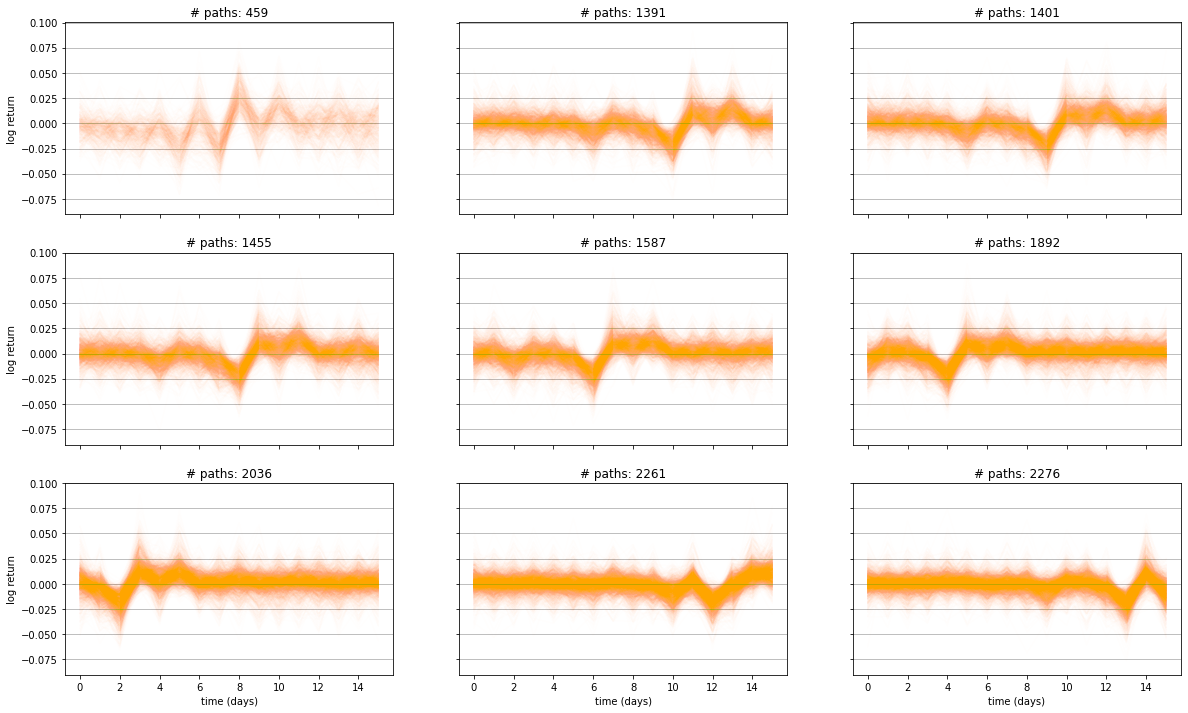

In [16]:
small_bins = np.argsort(total_freq[:, 1])[:9]
fig, ax = plot_clustering(synth_samples, synth_bins, 0.006, small_bins, (20, 12));

plt.savefig('wgan_clusters_small.png', dpi=300)
files.download("wgan_clusters_small.png");

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

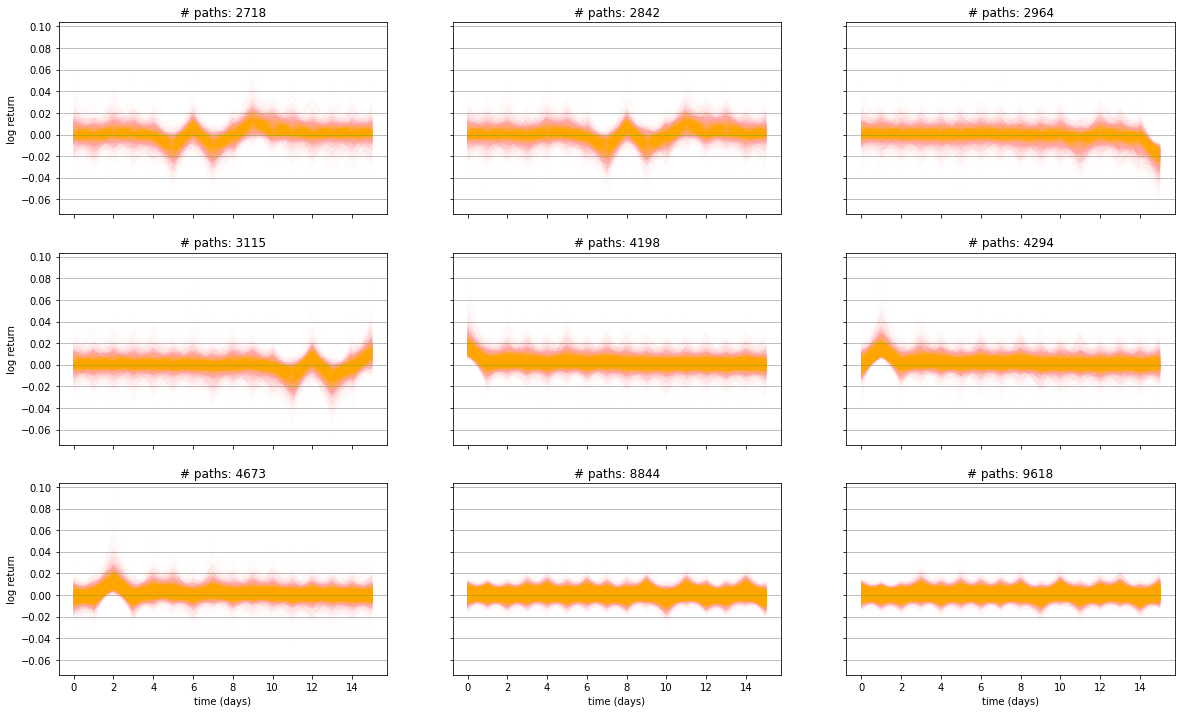

In [17]:
big_bins = np.argsort(total_freq[:, 1])[-9:]
fig, ax = plot_clustering(synth_samples, synth_bins, 0.003, big_bins, (20, 12))

plt.savefig('wgan_clusters_big.png', dpi=300)
files.download("wgan_clusters_big.png");